In [1]:
import pytorch_lightning as pl
from phantoms.models.retrieval.gnn_retrieval_model import GNNRetrievalModel  # Existing small model
from phantoms.models.retrieval.gnn_retrieval_model_skip_connection import GNNRetrievalSkipConnections  # New large model
from massspecgym.data.data_module import MassSpecDataModule
from massspecgym.data.transforms import MolFingerprinter
from massspecgym.featurize import SpectrumFeaturizer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from massspecgym.data.datasets import MSnRetrievalDataset, MSnDataset
import yaml
import argparse
import os
import numpy as np
import torch

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_embeddings(model, dataloader, save_dir):
    """
    Extract embeddings from the model for the entire dataset and save them.

    Args:
        model: Trained model with a get_embeddings method.
        dataloader: DataLoader for the dataset.
        save_dir: Directory to save the embeddings.
    """
    model.eval()
    embeddings_dict = {}

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            data = batch['spec']
            embeddings = model.get_embeddings(data)  # Dict of embeddings

            for layer_name, embed in embeddings.items():
                if layer_name not in embeddings_dict:
                    embeddings_dict[layer_name] = []
                embeddings_dict[layer_name].append(embed.numpy())

    # Concatenate all batches for each layer and save
    for layer_name, embed_list in embeddings_dict.items():
        layer_embeddings = np.concatenate(embed_list, axis=0)  # Shape: [total_samples, embedding_dim]
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{layer_name}.npy")
        np.save(save_path, layer_embeddings)

In [3]:
def train_models(config, cut_tree_levels):
    """
    Train separate models for each cut_tree_at_level.

    Args:
        config (dict): Configuration dictionary.
        cut_tree_levels (list): List of cut_tree_at_level values.
    """
    for level in cut_tree_levels:
        # Define experiment-specific parameters
        experiment_name = f"{config.get('experiment_base_name', 'experiment')}_cut_tree_{level}"
        print(f"Starting training for {experiment_name}")

        # Initialize Featurizer
        featurizer = SpectrumFeaturizer(config['featurizer'], mode='torch')

        # Initialize Dataset with specific cut_tree_at_level
        dataset_msn = MSnRetrievalDataset(
            pth=config['data']['file_mgf'],
            candidates_pth=config['data']['file_json'],
            featurizer=featurizer,
            mol_transform=MolFingerprinter(fp_size=config['model']['fp_size']),
            cut_tree_at_level=level,
            max_allowed_deviation=config['data']['max_allowed_deviation']
        )

        # Initialize DataModule
        data_module_msn = MassSpecDataModule(
            dataset=dataset_msn,
            batch_size=config['data']['batch_size'],
            split_pth=config['data']['split_file'],
            num_workers=config['data']['num_workers']
        )

        # Select Model Type (Assuming 'large' for SkipConnections)
        model = GNNRetrievalSkipConnections(
            hidden_channels=config['model']['hidden_channels'],
            out_channels=config['model']['fp_size'],
            node_feature_dim=config['model']['node_feature_dim'],
            dropout_rate=config['model'].get('dropout_rate', 0.2),
            bottleneck_factor=config['model'].get('bottleneck_factor', 1.0),
            num_skipblocks=config['model'].get('num_skipblocks', 3),
            num_gcn_layers=config['model'].get('num_gcn_layers', 3),
            use_formula=config['model'].get('use_formula', False),
            formula_embedding_dim=config['model'].get('formula_embedding_dim', 64),
            at_ks=config['metrics']['at_ks'],
            lr=config['optimizer']['lr'],
            weight_decay=config['optimizer']['weight_decay']
        )

        # Initialize Loggers
        tb_logger = TensorBoardLogger(
            save_dir=config['logs']['dir'],
            name=config['logs']['name'],
            version=experiment_name
        )

        # wandb_logger = WandbLogger(
        #     project=config['wandb']['project'],
        #     entity=config['wandb']['entity'],
        #     name=experiment_name,
        #     log_model="all"
        # )

        # Define experiment-specific checkpoint directory
        checkpoint_dir = os.path.join(config['trainer']['checkpoint_dir'], experiment_name)
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Initialize Trainer with both TensorBoard and W&B loggers
        trainer = pl.Trainer(
            accelerator=config['trainer']['accelerator'],
            devices=config['trainer']['devices'],
            max_epochs=config['trainer']['max_epochs'],
            logger=[tb_logger],
            log_every_n_steps=config['trainer']['log_every_n_steps'],
            limit_train_batches=config['trainer']['limit_train_batches'],
            limit_val_batches=config['trainer']['limit_val_batches'],
            limit_test_batches=config['trainer']['limit_test_batches'],
            callbacks=[
                pl.callbacks.ModelCheckpoint(
                    monitor=config['trainer']['checkpoint_monitor'],
                    save_top_k=config['trainer']['save_top_k'],
                    mode=config['trainer']['checkpoint_mode'],
                    dirpath=checkpoint_dir,
                    filename='gnn_retrieval-{epoch:02d}-{val_loss:.2f}'
                ),
                pl.callbacks.LearningRateMonitor(logging_interval='step')
            ]
        )

        # Train the model
        trainer.fit(model, datamodule=data_module_msn)

        # Test the model
        trainer.test(model, datamodule=data_module_msn)

        # Save the trained model (optional)
        model_save_path = os.path.join(checkpoint_dir, 'final_model.ckpt')
        trainer.save_checkpoint(model_save_path)
        print(f"Model saved to {model_save_path}")

def extract_and_save_embeddings(config, cut_tree_levels):
    """
    Extract and save embeddings from trained models.

    Args:
        config (dict): Configuration dictionary.
        cut_tree_levels (list): List of cut_tree_at_level values.
    """
    for level in cut_tree_levels:
        # Define experiment-specific parameters
        experiment_name = f"{config.get('experiment_base_name', 'experiment')}_cut_tree_{level}"
        print(f"Extracting embeddings for {experiment_name}")

        # Load the trained model
        checkpoint_path = os.path.join(config['trainer']['checkpoint_dir'], experiment_name, 'final_model.ckpt')
        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint not found for {experiment_name} at {checkpoint_path}. Skipping embedding extraction.")
            continue

        model = GNNRetrievalSkipConnections.load_from_checkpoint(
            checkpoint_path,
            hidden_channels=config['model']['hidden_channels'],
            out_channels=config['model']['fp_size'],
            node_feature_dim=config['model']['node_feature_dim'],
            dropout_rate=config['model'].get('dropout_rate', 0.2),
            bottleneck_factor=config['model'].get('bottleneck_factor', 1.0),
            num_skipblocks=config['model'].get('num_skipblocks', 3),
            num_gcn_layers=config['model'].get('num_gcn_layers', 3),
            use_formula=config['model'].get('use_formula', False),
            formula_embedding_dim=config['model'].get('formula_embedding_dim', 64),
            at_ks=config['metrics']['at_ks'],
            lr=config['optimizer']['lr'],
            weight_decay=config['optimizer']['weight_decay']
        )
        model.eval()

        # Initialize Featurizer
        featurizer = SpectrumFeaturizer(config['featurizer'], mode='torch')

        # Initialize Dataset with specific cut_tree_at_level
        dataset_msn = MSnRetrievalDataset(
            pth=config['data']['file_mgf'],
            candidates_pth=config['data']['file_json'],
            featurizer=featurizer,
            mol_transform=MolFingerprinter(fp_size=config['model']['fp_size']),
            cut_tree_at_level=level,
            max_allowed_deviation=config['data']['max_allowed_deviation']
        )

        # Initialize DataModule
        data_module_msn = MassSpecDataModule(
            dataset=dataset_msn,
            batch_size=config['data']['batch_size'],
            split_pth=config['data']['split_file'],
            num_workers=config['data']['num_workers']
        )
        
        # TODO add test loader
        data_module_msn.prepare_data()
        data_module_msn.setup("test")

        # Define embedding save directory
        embeddings_save_dir = os.path.join('embeddings', experiment_name)
        os.makedirs(embeddings_save_dir, exist_ok=True)

        # Use the test dataloader for embeddings extraction
        test_loader = data_module_msn.test_dataloader()

        print(f"Extracting embeddings for {experiment_name}")
        save_embeddings(model, test_loader, embeddings_save_dir)
        print(f"Embeddings saved to {embeddings_save_dir}")


In [10]:
pl.seed_everything(42)

config_path = "/Users/macbook/CODE/PhantoMS/phantoms/models/retrieval/configs/config_skip_connection_dreams.yml"
# Load configuration
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

Seed set to 42


In [11]:
featurizer = SpectrumFeaturizer(config['featurizer'], mode='torch')
dataset_msn = MSnRetrievalDataset(
    pth=config['data']['file_mgf'],
    candidates_pth=config['data']['file_json'],
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=config['model']['fp_size']),
    cut_tree_at_level=4,
    max_allowed_deviation=config['data']['max_allowed_deviation']
)

Total valid indices: 105
Dataset length: 105


In [7]:
len(dataset_msn)

105

In [ ]:
len(dataset_msn)

In [11]:
# Define different cut_tree_at_level values
cut_tree_levels = [3, 4]

# Step 1: Train all models
train_models(config, cut_tree_levels)

Starting training for skip_tree_cut_tree_3
Total valid indices: 99
Dataset length: 99


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                        | Params | Mode 
-------------------------------------------------------------------
0 | gcn_layers | ModuleList                  | 10.5 M | train
1 | head       | SkipConnectionRetrievalHead | 37.8 M | train
2 | loss_fn    | BCEWithLogitsLoss           | 0      | train
-------------------------------------------------------------------
48.3 M    Trainable params
0   

Train dataset size: 76
Val dataset size: 6
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


in collate_fn
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s]in collate_fn
                                                                           

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s, v_num=ee_3, train_loss=0.723]
Validation: |          | 0/? [00:00<?, ?it/s]in collate_fn

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 30.44it/s]in collate_fn

Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s, v_num=ee_3, train_loss=0.238, val_loss=0.572]
Validation: |          | 0/? [00:00<?, ?it/s]in collate_fn

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 29.94it/s]in collate_fn

Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, v_num=ee_3, train_loss=0.154, val_loss=0.389]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, v_num=ee_3, train_loss=0.154, val_loss=0.389]

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Test dataset size: 17
Testing: |          | 0/? [00:00<?, ?it/s]in collate_fn
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_hit_rate@1                0.0
    test_hit_rate@20                0.5
     test_hit_rate@5                0.0
        test_loss            0.407480925321579
       test_mces@1                 26.25
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model saved to checkpoints/skip_tree_cut_tree_3/final_model.ckpt
Starting training for skip_tree_cut_tree_4
Total valid indices: 99
Dataset length: 99


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                        | Params | Mode 
-------------------------------------------------------------------
0 | gcn_layers | ModuleList                  | 10.5 M | train
1 | head       | SkipConnectionRetrievalHead | 37.8 M | train
2 | loss_fn    | BCEWithLogitsLoss           | 0      | train
-------------------------------------------------------------------
48.3 M    Trainable params
0   

Train dataset size: 76
Val dataset size: 6
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


in collate_fn
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 29.42it/s]in collate_fn
                                                                           

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s, v_num=ee_4, train_loss=0.715]
Validation: |          | 0/? [00:00<?, ?it/s]in collate_fn

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 29.57it/s]in collate_fn

Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, v_num=ee_4, train_loss=0.236, val_loss=0.617]
Validation: |          | 0/? [00:00<?, ?it/s]in collate_fn

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 36.62it/s]in collate_fn

Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.88it/s, v_num=ee_4, train_loss=0.146, val_loss=0.452]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.73it/s, v_num=ee_4, train_loss=0.146, val_loss=0.452]

/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Test dataset size: 17
Testing: |          | 0/? [00:00<?, ?it/s]in collate_fn
Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_hit_rate@1                0.0
    test_hit_rate@20               0.75
     test_hit_rate@5                0.5
        test_loss           0.4609449505805969
       test_mces@1                 19.25
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model saved to checkpoints/skip_tree_cut_tree_4/final_model.ckpt


In [12]:
extract_and_save_embeddings(config, cut_tree_levels)

Extracting embeddings for skip_tree_cut_tree_3


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Total valid indices: 99
Dataset length: 99
Test dataset size: 17
Extracting embeddings for skip_tree_cut_tree_3
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
Embeddings saved to embeddings/skip_tree_cut_tree_3
Extracting embeddings for skip_tree_cut_tree_4


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Total valid indices: 99
Dataset length: 99
Test dataset size: 17
Extracting embeddings for skip_tree_cut_tree_4
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
in collate_fn
Embeddings saved to embeddings/skip_tree_cut_tree_4


# Embeddings

In [18]:
os.listdir("/Users/macbook/CODE/PhantoMS/notebooks/embeddings/skip_tree_cut_tree_3")

['head_head_fc1.npy',
 'gcn2.npy',
 'gcn3.npy',
 'gcn1.npy',
 'head_skipblock_1.npy',
 'head_skipblock_2.npy',
 'head_skipblock_3.npy',
 'head_head_fc_final.npy']

In [19]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.

    Args:
        experiment_dir (str): Path to the experiment's embedding directory.
        layer_names (list): List of layer names to load embeddings for.

    Returns:
        dict: Mapping from layer name to its embedding matrix.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings

from phantoms.utils.CKA.CKA import linear_CKA, kernel_CKA

def compute_layer_cka(embeddings_model1, embeddings_model2, layer_name1, layer_name2):
    """
    Compute CKA scores between two models for a specific layer.

    Args:
        embeddings_model1 (dict): Embeddings from model 1.
        embeddings_model2 (dict): Embeddings from model 2.
        layer_name1 (str): The layer to compare.
        layer_name2 (str): The layer to compare.

    Returns:
        tuple: (linear_cka_score, rbf_cka_score)
    """
    X = embeddings_model1.get(layer_name1)
    Y = embeddings_model2.get(layer_name2)
    
    if X is None or Y is None:
        print(f"Embeddings for layer '{layer_name1}' or '{layer_name2}' are missing in one of the models.")
        return None, None
    
    # Transpose to shape (embedding_dim, num_samples)
    X = X.T
    Y = Y.T
    
    # Compute CKA scores
    linear_cka_score = linear_CKA(X, Y)
    rbf_cka_score = kernel_CKA(X, Y)
    
    return linear_cka_score, rbf_cka_score

In [20]:
experiment_dir1 = '/Users/macbook/CODE/PhantoMS/notebooks/embeddings/skip_tree_cut_tree_3'
experiment_dir2 = '/Users/macbook/CODE/PhantoMS/notebooks/embeddings/skip_tree_cut_tree_4'

# Specify the layers you want to compare
layer_names = ['head_head_fc1',
 'gcn2',
 'gcn3',
 'gcn1',
 'head_skipblock_1',
 'head_skipblock_2',
 'head_skipblock_3',
 'head_head_fc_final']


In [21]:
embeddings_model1 = load_embeddings(experiment_dir1, layer_names)
embeddings_model2 = load_embeddings(experiment_dir2, layer_names)

In [22]:
# Compute and display CKA scores for each layer
for layer in layer_names:
    linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer, layer)
    if linear_cka is not None and rbf_cka is not None:
        print(f"Layer: {layer}")
        print(f"  Linear CKA: {linear_cka:.4f}")
        print(f"  RBF Kernel CKA: {rbf_cka:.4f}\n")

Layer: head_head_fc1
  Linear CKA: 0.0014
  RBF Kernel CKA: 0.0032

Layer: gcn2
  Linear CKA: 0.0005
  RBF Kernel CKA: 0.0011

Layer: gcn3
  Linear CKA: 0.0001
  RBF Kernel CKA: 0.0009

Layer: gcn1
  Linear CKA: 0.0025
  RBF Kernel CKA: 0.0057

Layer: head_skipblock_1
  Linear CKA: 0.0003
  RBF Kernel CKA: 0.0012

Layer: head_skipblock_2
  Linear CKA: 0.0024
  RBF Kernel CKA: 0.0041

Layer: head_skipblock_3
  Linear CKA: 0.0002
  RBF Kernel CKA: 0.0009

Layer: head_head_fc_final
  Linear CKA: 0.0002
  RBF Kernel CKA: 0.0014



In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cka_scores(cka_scores, layer_names, model_names, title="CKA Heatmap"):
    """
    Plot a heatmap of CKA scores.

    Args:
        cka_scores (np.ndarray): 2D array of CKA scores.
        layer_names (list): List of layer names.
        model_names (list): List of model names.
        title (str): Title of the heatmap.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(cka_scores, annot=True, fmt=".2f",
                xticklabels=model_names, yticklabels=layer_names,
                cmap='viridis')
    plt.xlabel('Model 2 Layers')
    plt.ylabel('Model 1 Layers')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [24]:
# Initialize a matrix to store CKA scores
# Rows: Model1 layers, Columns: Model2 layers
cka_matrix = np.zeros((len(layer_names), len(layer_names), 2))  # Last dim for linear and RBF

for i, layer1 in enumerate(layer_names):
    for j, layer2 in enumerate(layer_names):
        linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer1, layer2)
        if linear_cka is not None and rbf_cka is not None:
            cka_matrix[i, j, 0] = linear_cka
            cka_matrix[i, j, 1] = rbf_cka

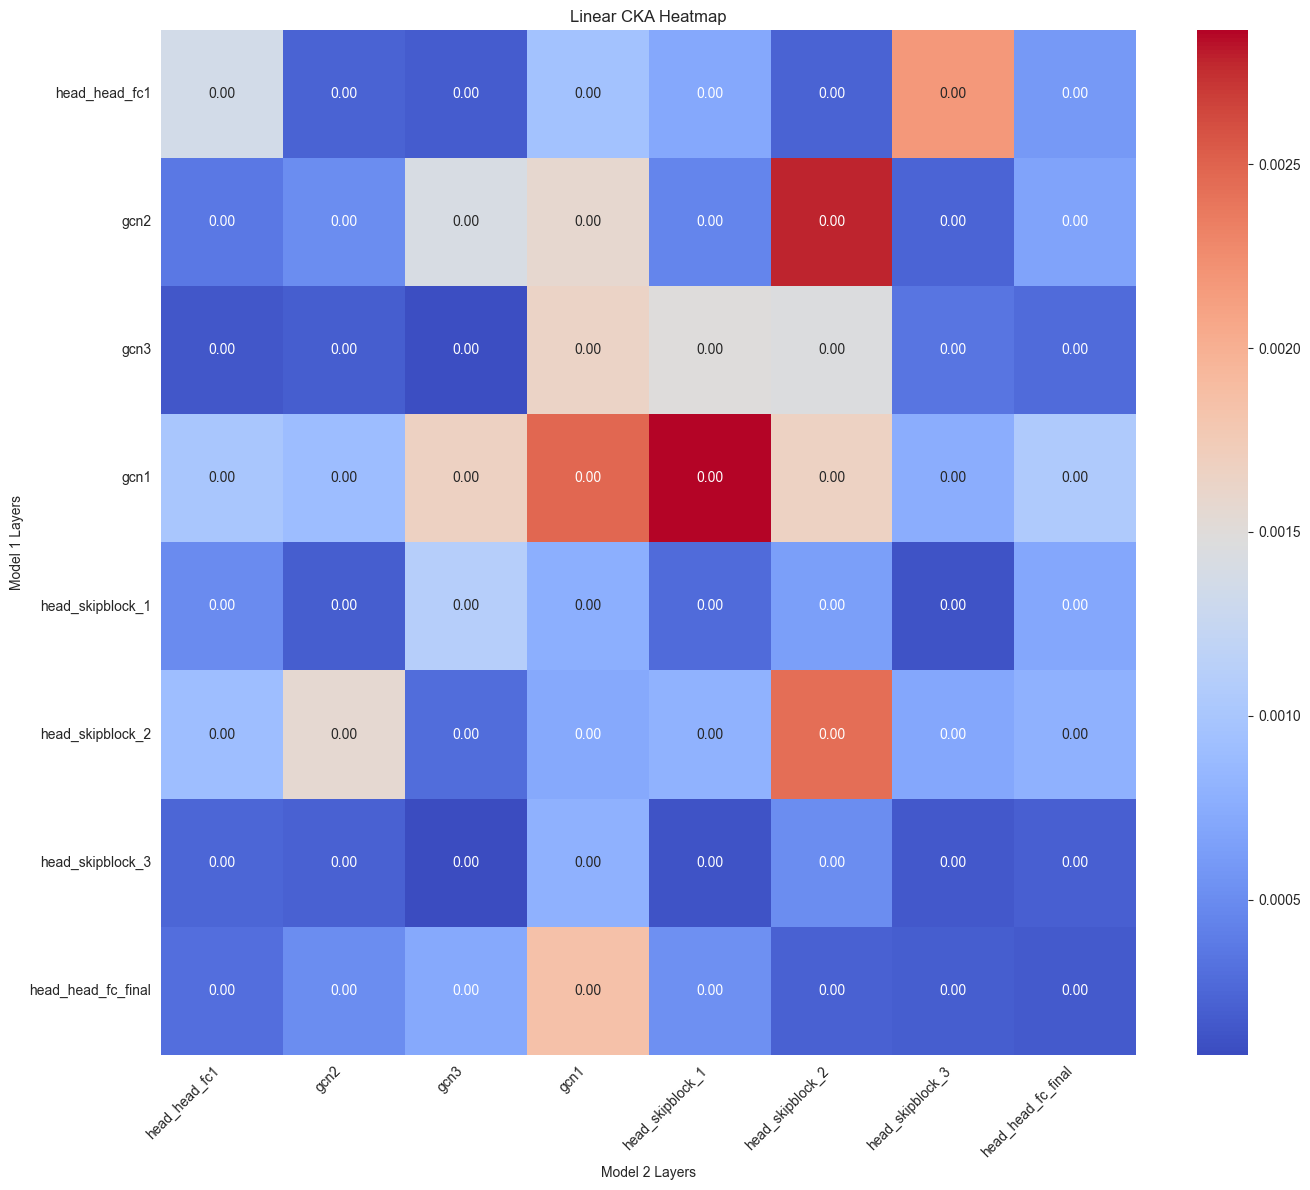

In [25]:
# Plot Linear CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:,:, 0], annot=True, fmt=".2f",
            xticklabels=layer_names, yticklabels=layer_names,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('Linear CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

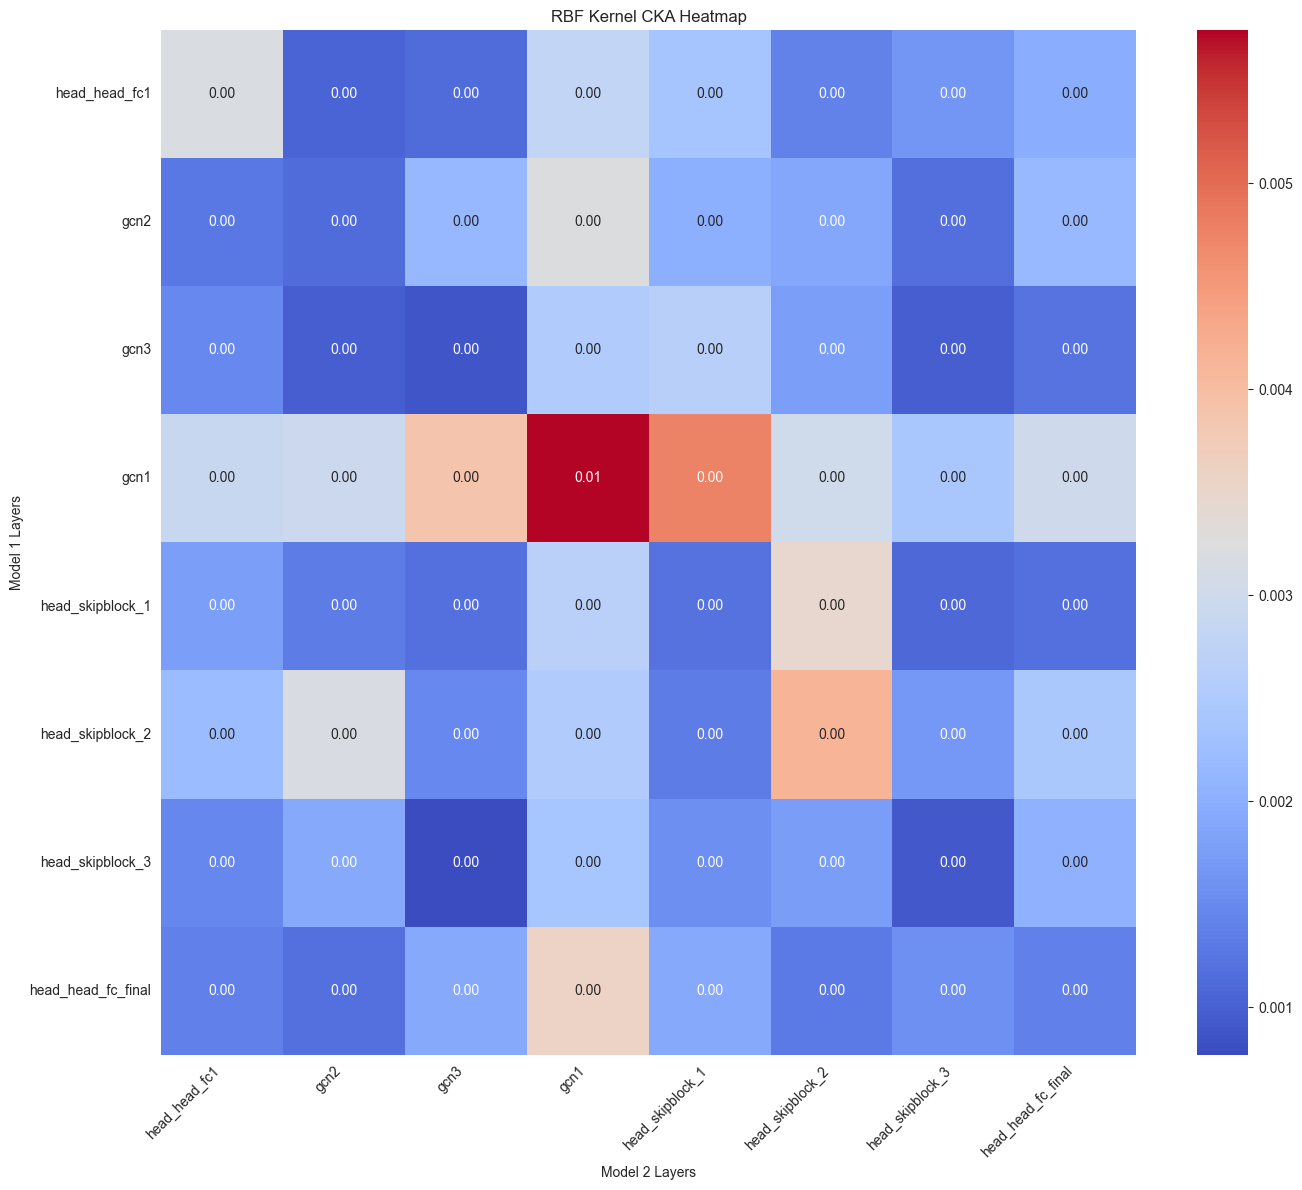

In [26]:
# Plot RBF Kernel CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:, :, 1], annot=True, fmt=".2f",
            xticklabels=layer_names, yticklabels=layer_names,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('RBF Kernel CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
model = GNNRetrievalSkipConnections(
    hidden_channels=config['model']['hidden_channels'],
    out_channels=config['model']['fp_size'],
    node_feature_dim=config['model']['node_feature_dim'],
    dropout_rate=config['model'].get('dropout_rate', 0.2),
    bottleneck_factor=config['model'].get('bottleneck_factor', 1.0),
    num_skipblocks=config['model'].get('num_skipblocks', 3),
    num_gcn_layers=config['model'].get('num_gcn_layers', 3),
    at_ks=config['metrics']['at_ks'],
    lr=config['optimizer']['lr'],
    weight_decay=config['optimizer']['weight_decay']
)


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [28]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

48304128


# Plot UMAP

In [29]:
import os
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
embeddings_model1 = load_embeddings(experiment_dir1, layer_names)
embeddings_model2 = load_embeddings(experiment_dir2, layer_names)

In [31]:
def project_embeddings_umap(embeddings_dict, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42, figsize=(12, 10), save_path=None):
    """
    Projects embeddings into 2D space using UMAP and plots them colored by layer.

    Args:
        embeddings_dict (dict): A dictionary where keys are layer names and values are np arrays of shape [num_samples, embedding_dim].
        n_neighbors (int): UMAP parameter. Controls local versus global structure in the data.
        min_dist (float): UMAP parameter. Controls how tightly UMAP packs points together.
        metric (str): UMAP parameter. The metric to use for distance computation.
        random_state (int): Random state for reproducibility.
        figsize (tuple): Size of the matplotlib figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Validate input
    if not isinstance(embeddings_dict, dict):
        raise ValueError("embeddings_dict must be a dictionary with layer names as keys and embedding arrays as values.")

    # Collect embeddings and labels
    all_embeddings = []
    labels = []
    for layer, emb in embeddings_dict.items():
        if not isinstance(emb, np.ndarray):
            raise ValueError(f"Embeddings for layer '{layer}' must be a NumPy array.")
        all_embeddings.append(emb)
        labels.extend([layer] * emb.shape[0])

    # Concatenate all embeddings
    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Total embeddings shape after concatenation: {concatenated_embeddings.shape}")

    # Create a DataFrame for UMAP
    df_embeddings = pd.DataFrame(concatenated_embeddings)
    df_embeddings['Layer'] = labels

    # Initialize UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)

    # Fit and transform the embeddings
    embedding_2d = reducer.fit_transform(df_embeddings.drop('Layer', axis=1))
    df_embeddings['UMAP1'] = embedding_2d[:, 0]
    df_embeddings['UMAP2'] = embedding_2d[:, 1]

    # Debugging: Check the shape of the reduced embeddings
    print(f"UMAP embedding shape: {embedding_2d.shape}")

    # Plotting
    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=df_embeddings,
        x='UMAP1',
        y='UMAP2',
        hue='Layer',
        palette='tab10',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP Projection of Layer Embeddings', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"UMAP plot saved to {save_path}")

    plt.show()

Total embeddings shape after concatenation: (136, 2048)


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP embedding shape: (136, 2)


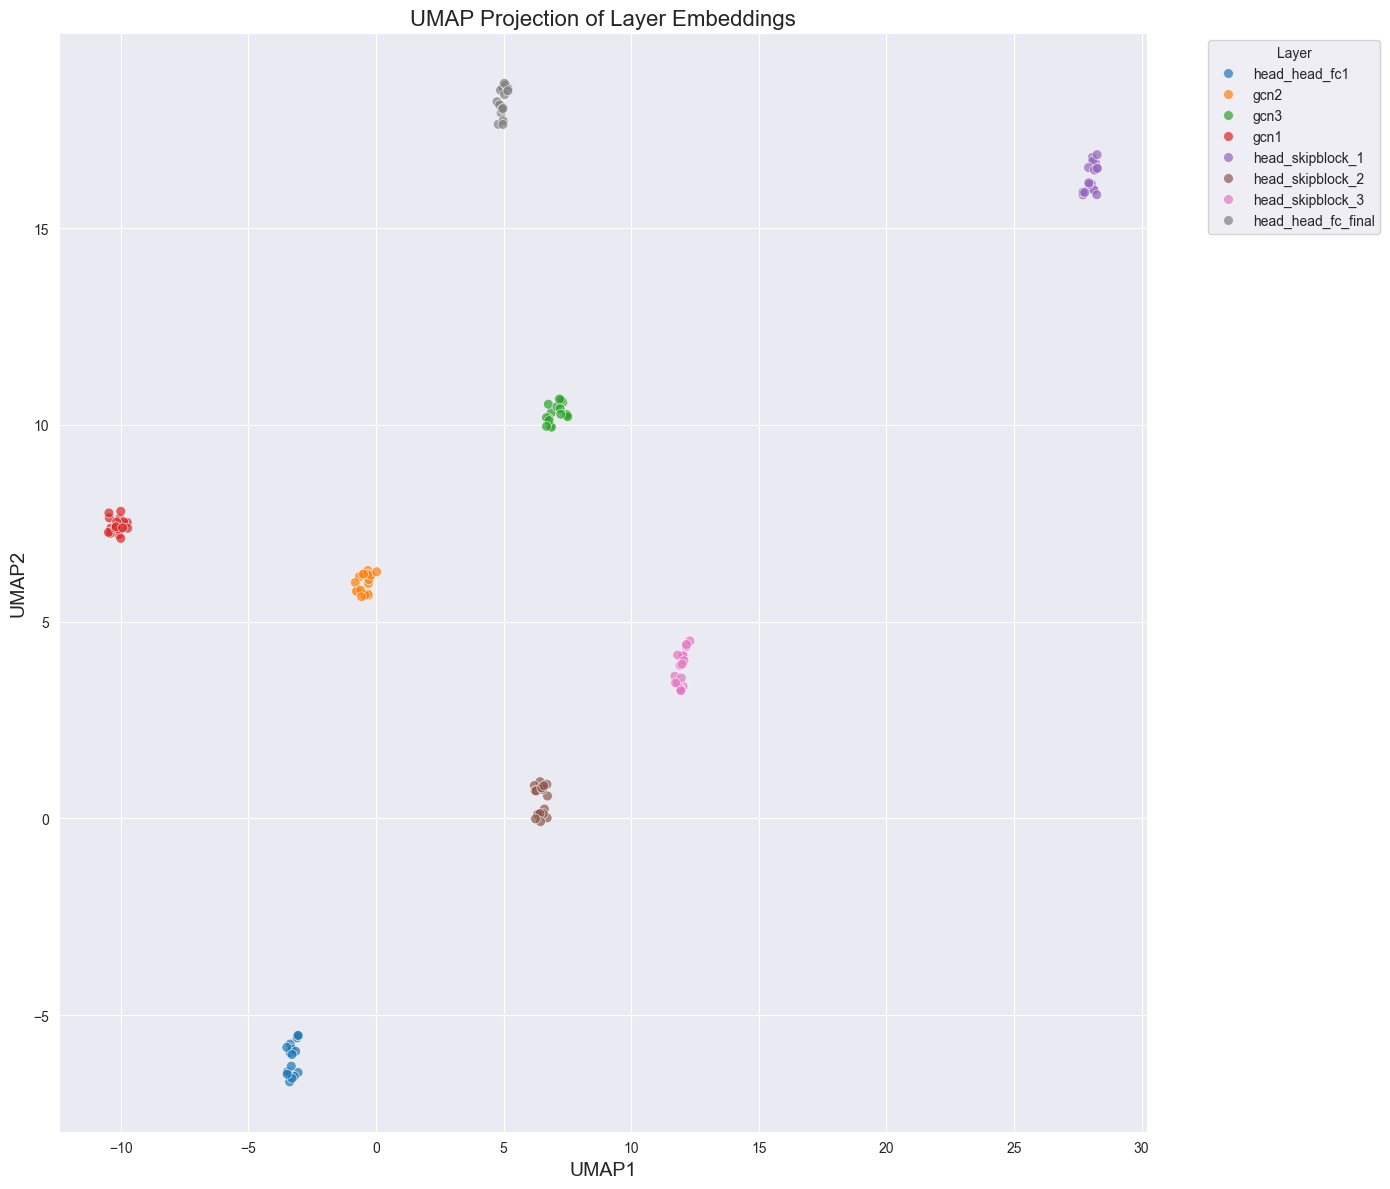

In [32]:
project_embeddings_umap(
    embeddings_dict=embeddings_model1,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    figsize=(14, 12),
    save_path=None
)